In [66]:
from sklearn.mixture import GaussianMixture as GMM
from matplotlib.patches import Ellipse
import cv2
import matplotlib.pyplot as plt
import numpy as np

""" Reading in image and getting pixel datapoint representation """

def read_image(file_name: str):
    return cv2.imread(file_name)

def colour2bw(image):
    grey_horse = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    (_, white_horse) = cv2.threshold(grey_horse, 10, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    return white_horse

def image2pixels(bw_image):    
    # Initialise arrays to store positions of each pixel
    x_pixels = np.zeros(len(bw_image.flatten()))
    y_pixels = np.zeros(len(bw_image.flatten()))
    # Store position of each pixel
    count = 0
    for row in range(bw_image.shape[0]):
        for column in range(bw_image.shape[1]):
            if bw_image[row,column] != 0:
                x_pixels[count] = column
                y_pixels[count] = -row
            count += 1
    # Remove datapoints where there are no pixels
    x_pixels = x_pixels[x_pixels != 0]
    y_pixels = y_pixels[y_pixels != 0]
    return x_pixels, y_pixels

def file2pixels(file_name: str):
    image = read_image(file_name)
    bw_image = colour2bw(image)
    x_pixels, y_pixels = image2pixels(bw_image)
    # Create dictionary to store data:
    image_data = {
        'image' : bw_image,
        'pixels': (x_pixels, y_pixels)
    }
    return image_data

""" Performing Gaussian Mixture Modelling """

def gmm_labels(pixel_datapoints: tuple, num_components: int):
    # Get data in and convert to array
    pixel_array = np.transpose(np.asarray(pixel_datapoints))
    # Fit gmm to data
    gmm_model = GMM(n_components=num_components, covariance_type= 'spherical', random_state=0).fit(pixel_array)
    # Get labels from the predictions
    gmm_labels = gmm_model.predict(pixel_array)
    return gmm_labels

""" Code for drawing elipses """

def draw_ellipse(position, covariance, ax=None):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    nsig = 1.7
    ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                         angle, color='k', fill=False))
        
def plot_gmm(gmm, horse, label=True, ax=None):
    ax = ax or plt.gca()
    gmm_labels = gmm.fit(horse_xy).predict(horse_xy)
    if label:
        ax.scatter(horse['pixels'][0], horse['pixels'][1], c=gmm_labels, s=0.5, cmap='viridis')
    else:
        ax.scatter(horse['pixels'][0], horse['pixels'][1], s=0.5)
    ax.axis('equal')
    
    for pos, covar in zip(gmm.means_, gmm.covariances_):
        draw_ellipse(pos, covar)

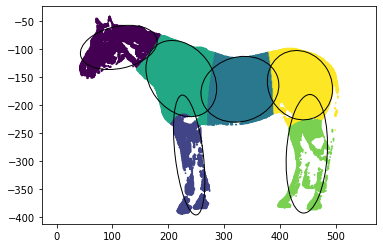

In [67]:
horse = file2pixels('Images/horse.png')

horse_xy = np.array(horse['pixels'][:])
horse_xy = np.transpose(horse_xy)

gmm = GMM(n_components=6, random_state=0)

plot_gmm(gmm, horse)

## Display images and pixel images

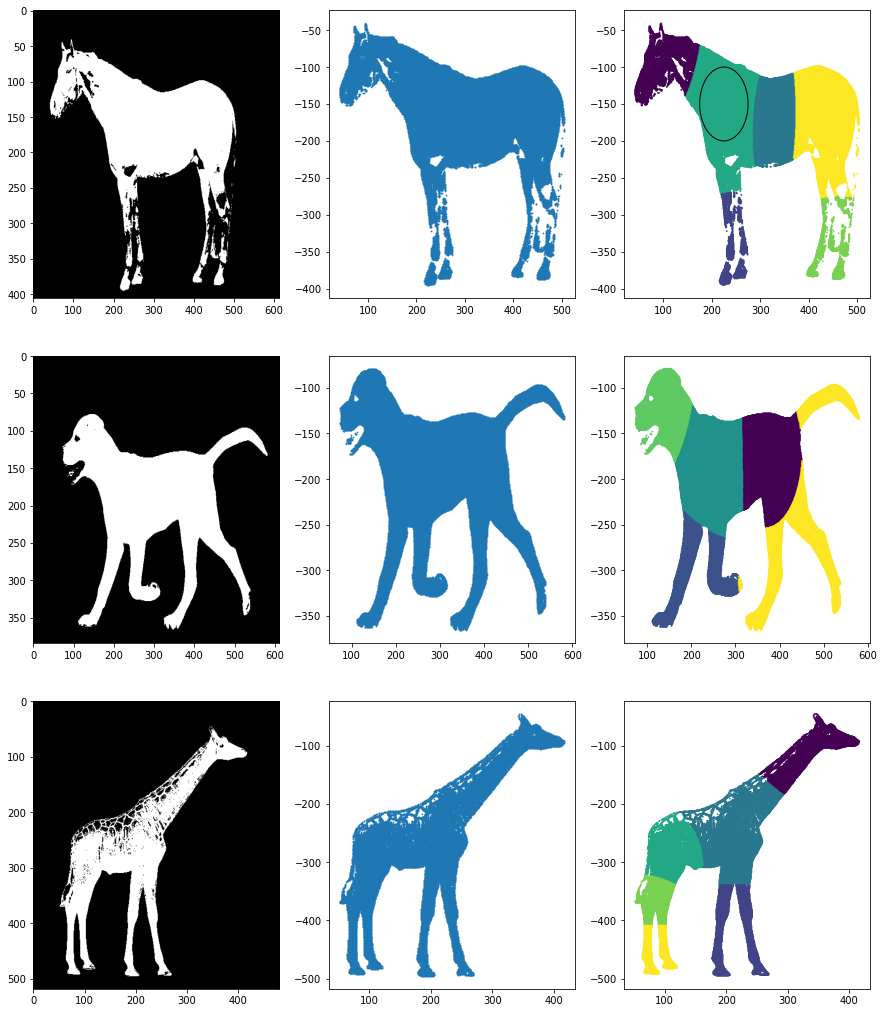

In [2]:
# Collect data
horse = file2pixels('Images/horse.png')
poochie = file2pixels('Images/DogNoBg.png')
giraffe = file2pixels('Images/GiraffeNoBG.png')

# Perform GMM and colect labels
horse['labels'] = gmm_labels(horse['pixels'], 6)
poochie['labels'] = gmm_labels(poochie['pixels'], 5)
giraffe['labels'] = gmm_labels(giraffe['pixels'], 6)

# Make figure
fig, ax = plt.subplots(3, 3, figsize=(15,18))

""" Horse Plotting """

# Plot horse
ax[0][0].imshow(horse['image'], cmap='gray', aspect='auto')
ax[0][1].scatter(horse['pixels'][0], horse['pixels'][1], s=0.5)
ax[0][2].scatter(horse['pixels'][0], horse['pixels'][1], c=horse['labels'], s=0.5, cmap='viridis')

# Plot horse circles
circle1 = plt.Circle((225, -150), 50, color='k', fill=False)
ax[0][2].add_patch(circle1)

""" Poochie plotting """

# Plot poochie
ax[1][0].imshow(poochie['image'], cmap='gray', aspect='auto')
ax[1][1].scatter(poochie['pixels'][0], poochie['pixels'][1], s=0.5)
ax[1][2].scatter(poochie['pixels'][0], poochie['pixels'][1], c=poochie['labels'], s=0.5, cmap='viridis')

""" Giraffe plotting """

# Plot giraffe
ax[2][0].imshow(giraffe['image'], cmap='gray', aspect='auto')
ax[2][1].scatter(giraffe['pixels'][0], giraffe['pixels'][1], s=0.5)
ax[2][2].scatter(giraffe['pixels'][0], giraffe['pixels'][1], c=giraffe['labels'], s=0.5, cmap='viridis')

# Hide axes
for array in ax:
    for a in array:
        a.axis('off')

plt.show()